In [0]:
import os
os.chdir("gdrive/My Drive/CS498DL/Assignment5/Policy Gradient")

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


episode: 0   score: 1.0    steps: 156     evaluation reward: 1.0
episode 0: model saving...
episode: 1   score: 2.0    steps: 219     evaluation reward: 1.5
episode: 2   score: 2.0    steps: 179     evaluation reward: 1.6666666666666667
episode: 3   score: 1.0    steps: 157     evaluation reward: 1.5
episode: 4   score: 6.0    steps: 361     evaluation reward: 2.4
episode: 5   score: 8.0    steps: 377     evaluation reward: 3.3333333333333335
episode: 6   score: 1.0    steps: 188     evaluation reward: 3.0
episode: 7   score: 1.0    steps: 174     evaluation reward: 2.75
episode: 8   score: 5.0    steps: 289     evaluation reward: 3.0
episode: 9   score: 3.0    steps: 215     evaluation reward: 3.0
episode: 10   score: 3.0    steps: 225     evaluation reward: 3.2
episode: 11   score: 7.0    steps: 248     evaluation reward: 3.7
episode: 12   score: 0.0    steps: 127     evaluation reward: 3.5
episode: 13   score: 7.0    steps: 254     evaluation reward: 4.1
episode: 14   score: 3.0    

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


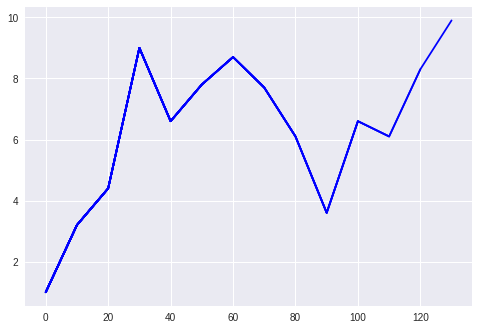

In [3]:
import os
import argparse
import gym
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
from collections import deque
from collections import deque
import numpy as np
import random
import numpy as np
from skimage.transform import resize
from skimage.color import rgb2gray
import pylab
import sys

gamma = 0.99
decay_rate = 0.99
learning_rate = 1e-4
batch_size = 10
seed = 87
HEIGHT = 84
WIDTH = 84
HISTORY_SIZE = 4
env = gym.make('BreakoutDeterministic-v4')
# print(env.observation_space.shape[0])
env.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

r = []
episodes = []

saved_log_probs = []
saved_rewards = []

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc = nn.Linear(3136, 512)
        self.head = nn.Linear(512, 3)
        
        
    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.fc(x.view(x.size(0), -1)))
        action_scores = self.head(x)
        return F.softmax(action_scores, dim=-1)


# built policy network
policy = Policy()
policy.to(device)


# construct a optimal function
optimizer = optim.RMSprop(policy.parameters(), lr=learning_rate, weight_decay=decay_rate)


def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    state = Variable(state).float().to(device)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample() 

    saved_log_probs.append(m.log_prob(action)) 
    return action.item()

def get_frame(X):
    x = np.uint8(resize(rgb2gray(X), (HEIGHT, WIDTH), mode='reflect') * 255)
    return x

def get_init_state(history, s):
    for i in range(HISTORY_SIZE):
        history[i, :, :] = get_frame(s)
        
def finish_episode():
    R = 0
    policy_loss = []
    rewards = []

    for r in saved_rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    # turn rewards to pytorch tensor and standardize
    rewards = torch.FloatTensor(rewards).to(device)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    
    for log_prob, reward in zip(saved_log_probs, rewards):
        policy_loss.append(torch.mul(-log_prob, reward))


    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()



# Main loop
running_reward = None
evaluation_reward = deque(maxlen=10)
for i_episode in range(500000):

    saved_log_probs = []
    saved_rewards = []
    
    step = 0
    score = 0
    state = env.reset()
    history = np.zeros([5, 84, 84], dtype=np.uint8)
    get_init_state(history, state)
    done = False
    while not done:
        action = select_action(np.float32(history[:4, :, :]) / 255.)

        step += 1
        action = action + 1
        state, reward, done, _ = env.step(action)
        score += reward
        
        saved_rewards.append(np.copy(reward))
        
        
        if done:
            evaluation_reward.append(score)

            print("episode:", i_episode, "  score:", score, "   steps:",  step,
                  "    evaluation reward:", np.mean(evaluation_reward))            

            if np.mean(evaluation_reward) > 10:
              torch.save(policy.state_dict(), 'save_model_png/breakout_pg.pkl')
              sys.exit()

           
    # use policy gradient update model weights
    if i_episode >= 1:
        finish_episode()

    # Save model in every 50 episode
    if i_episode % 50 == 0:
        print('episode %d: model saving...' % (i_episode))
        torch.save(policy.state_dict(), 'save_model_png/breakout_pg.pkl')
    if i_episode % 10 == 0:
        r.append(np.mean(evaluation_reward))
        episodes.append(i_episode)
        pylab.plot(episodes, r, 'b')
        pylab.savefig("save_model_png/breakout_pg.png")